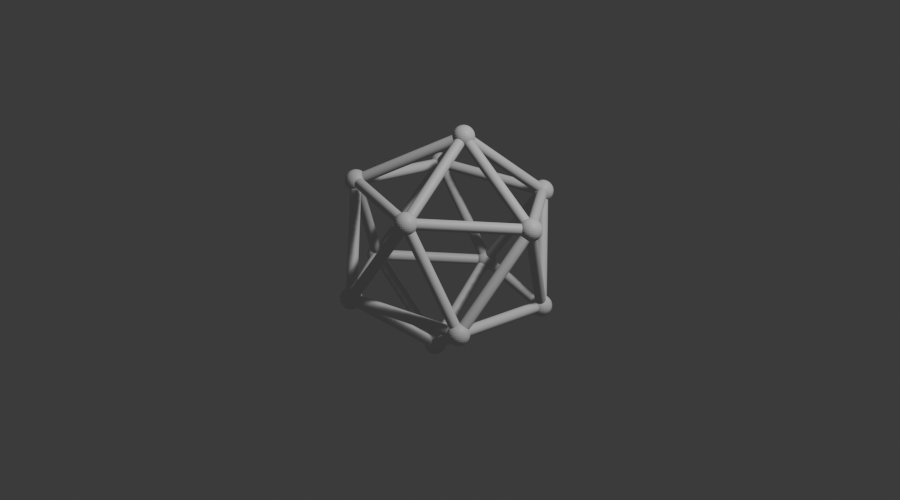

In [9]:
import networkx as nx
import bpy
import numpy as np


G = nx.icosahedral_graph()
node_positions = nx.spring_layout(G, dim=3)
edges = list(G.edges)

blendfile_path = "networkx.blend"
with bpy.data.libraries.load(blendfile_path, link=False) as (data_from, data_to):
    if 'connector_node' in data_from.node_groups:
        data_to.node_groups = ['connector_node']

# Check if the 'add_raindrops' node group is now loaded
if 'connector_node' in bpy.data.node_groups:
    raindrop_node_group = bpy.data.node_groups['connector_node']
else:
    raise NameError("The 'connector_node' geometry node group could not be found in the Blender file.")

# Clear existing objects
collection = bpy.data.collections.get("Collection")
if collection:
    for obj in collection.objects:
        if obj.type not in {'CAMERA', 'LIGHT'}:
            bpy.data.objects.remove(obj, do_unlink=True)
            
# Delete all node groups that start with "connector_node" except the original "connector_node" 
for node_group in bpy.data.node_groups:
    if node_group.name.startswith("connector_node") and node_group.name != "connector_node":
        bpy.data.node_groups.remove(node_group)

# Create spheres at the points
spheres = {}
for key, coords in node_positions.items():
    bpy.ops.mesh.primitive_uv_sphere_add(location=(coords[0], coords[1], coords[2]), radius=0.1)
    sphere = bpy.context.object
    sphere.name = f"my_point{key}"
    spheres[key] = sphere

# Create a copy of the node group to use for each edge
node_group = bpy.data.node_groups.get("connector_node")


# Create plane objects at the center of each edge and add geometry nodes modifier
for i, (edge1, edge2) in enumerate(edges):
    bpy.ops.mesh.primitive_plane_add(size=0.2)  
    plane = bpy.context.object
    plane.name = f"edge{i+1}"
    
    # Duplicate the geometry nodes modifier node group for each edge
    new_node_group = node_group.copy()
    new_node_group.name = f"connector_node_{i+1}"
    modifier = plane.modifiers.new(name="connector_node", type='NODES')
    modifier.node_group = new_node_group
    

    # Collect Object Info nodes into a list
    object_info_nodes = [node for node in new_node_group.nodes if node.type == 'OBJECT_INFO']
    
    # Set the Object Info nodes to point to the corresponding spheres
    
    sphere1 = bpy.data.objects.get(f"my_point{edge1}")
    sphere2 = bpy.data.objects.get(f"my_point{edge2}")
    
    object_info_nodes[0].inputs[0].default_value = sphere1
    object_info_nodes[1].inputs[0].default_value = sphere2


path = "/tmp/test.png"
bpy.context.scene.render.filepath = path
bpy.ops.render.render(write_still=True)

bpy.context.scene.render.resolution_x = 900
bpy.context.scene.render.resolution_y = 500

from IPython.display import display, Image
display(Image(filename=path))

In [8]:
import sys
import os

sys.stdout = open(os.devnull, 'w')
sys.stderr = open(os.devnull, 'w')